# Modeling Non-Stationary Generalized Extreme Value (GEV) Distribution

In this example, we will import a precipitation **Annual Maxima Series (AMS)** for a **60-minute duration**, extracted from a continuous rainfall record available at **15-minute resolution** from the COOP station **USC00092485** located in **Georgia, USA**.

- The **station metadata** are available in the file: `station_metadata.json`.
- The **annual maxima series**, covering the period **1975–2024** (50 years of record), is provided in the file: `Annual_maxima_series.csv`.

> **Note:** The AMS values are real observations from the station. However, the climate covariates used in this analysis (e.g., temperature anomaly and north atlantic oscillation (NAO) index) are **synthetically generated** for demonstration purposes.

We will explore the relationship between extreme rainfall and climate covariates, and fit a non-stationary GEV model using selected covariates.


In [2]:
import nsEVDx as ns
import numpy as np
from scipy.stats import genextreme
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Markdown,display, HTML

#### Loading AMS and Covariates

In [2]:
# Annual maxima series
AMS_df = pd.read_csv('data/Annual_maxima_series.csv',index_col=0)
print(AMS_df.head(3))

# Covariates
cov_df  = pd.read_csv('data/temp_anomaly_&_NAO.csv',index_col=0)
print(cov_df.head(3))

   year  60_min_maxima
0  1975          22.86
1  1976          48.26
2  1977          53.34
   year  temp_anomaly   NAO
0  1975          0.00 -2.21
1  1976          0.00 -1.53
2  1977          0.01 -1.35


#### Visualizing the input data

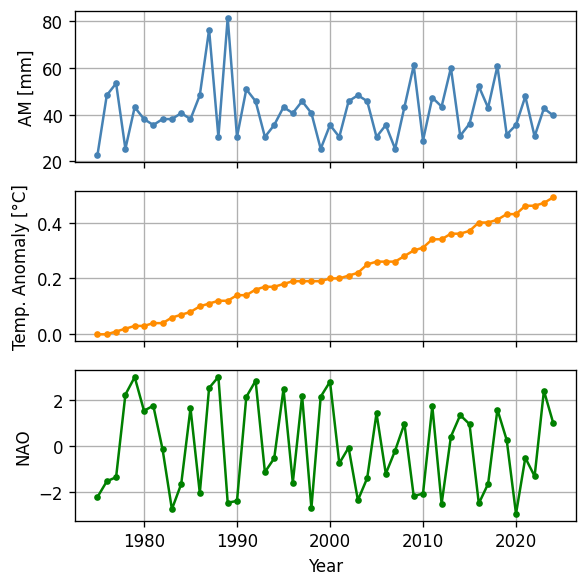

In [3]:
# Merge dataframes on 'year'
df = pd.merge(AMS_df, cov_df, on='year')

# Variables to plot
variables = ['60_min_maxima', 'temp_anomaly', 'NAO']
titles = ['AM [mm]', 'Temp. Anomaly [°C]', 'NAO']
colors = ['steelblue', 'darkorange', 'green']

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True, dpi=120)
for i, var in enumerate(variables):
    axs[i].plot(df['year'], df[var], color=colors[i], marker='.')
    axs[i].set_ylabel(titles[i])
    axs[i].grid(True)
    
axs[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()

#### Preparing Covariates and AMS data for Non-Stationary GEV Sampler

To model a non-stationary GEV distribution, we must prepare the **covariate matrix** including **time vector** in a format compatible with the sampler. This typically means:

1. **Converting covariates into a NumPy array**, ensuring they are aligned with the response variable (e.g., AMS).
2. **Centering the time variable** (e.g., years) by subtracting the mid-point of the record period. This helps reduce multicollinearity and improve MCMC convergence.

- Our record spans from 1975 to 2024. So, the mid-year is:
- mid_year = int((1975 + 2024) / 2)  =  1999
  ```python
  cov_df['year'] = cov_df['year'] - 1999
  ```

In [4]:
data = AMS_df['60_min_maxima'].values # data should be in chronological order
cov_df['year'] = cov_df['year'] - 1999
cov_df.head(3)

# Here, if you mess up the time covariate by running this block multiple times,
# please load AMS and Covariates again

,year,temp_anomaly,NAO
0,-24,0.00,-2.21
1,-23,0.00,-1.53
2,-22,0.01,-1.35


In [13]:
# Transposing the covariate as per the need of sampler
cov = cov_df.values.T
cov.shape

(3, 50)

#### Estimating the stationary GEV parameters 
In the following block, we estimate the stationary Generalized Extreme Value (GEV) parameters. This serves two key purposes:
- To obtain a realistic initial guess for the non-stationary model parameters.
- To define appropriate prior distributions for Bayesian estimation.

In [6]:
shape, loc, scale = ns.EVD_parsViaMLE(data,genextreme)
print(f"Shape : {shape}, Loc : {loc}, Scale : {scale}")

Shape : -0.01450631540755153, Loc : 36.210492227397154, Scale : 9.047095267044186


#### Setting up the Non-Stationary GEV Sampler
We now configure the non-stationary GEV model by specifying which parameters are modeled as functions of covariates. This is done using a config list:
```python
config = [2, 1, 0]
```
means:
- Location (μ) is a linear function of two covariates (intercept + 2 covariates, i.e., first and second)
- Scale (σ) is a linear function of one covariate (intercept + 1 covariate, i.e., first only)
- Shape (ξ) is constant (no covariate dependency)

We also define the prior distributions for each parameter, which guide the Bayesian estimation:
- Normal priors for regression coefficients of location and scale.
- Uniform prior for the intercept of log-scale (to ensure positivity).
- Normal prior for the shape parameter centered around the stationary estimate.
- Then, we initialize the NonStationaryEVD sampler using this configuration.

Even if users do not specify the priors, the MCMC samplers will automatically infer them, as the following line is embedded within each sampler.

```python
sampler.prior_specs = sampler.suggest_priors()
```
The same applies to parameter bounds when using the frequentist method. For faster convergence and to avoid errors, defining priors explicitly is more appropriate. Users can either pass this `prior_specs` list as an argument when instantiating the sampler, or assign it to the sampler later.

In [7]:
config = [2, 1, 0]
# Prior: normal for regression coefficients, uniform for scale, normal for shape
prior_specs = [
    ('normal', {'loc': loc, 'scale':loc*0.5 }),  # B0 scale = high -low, high = 20+10=30
    ('normal', {'loc': 0, 'scale': 0.05}),  # B1
    ('normal', {'loc': 0, 'scale': 0.05}), # B2
     ('uniform', {'loc': np.log(scale)*0.5, 'scale': np.log(scale)*1.6-np.log(scale)*0.5 }),   # a0
     ('normal', {'loc': 0, 'scale': 0.5}),   # a1
     ('normal', {'loc': shape, 'scale': 0.01})  # xi
]
sampler = ns.NonStationaryEVD(config, data, cov,dist=genextreme,
                                  prior_specs=prior_specs)
print(sampler.descriptions) # descriptions of the GEV parameters that sampler is going to sample/estimate
# It is recommended to check this output, as a mismatch between the number of prior_specs, 
# length of initial_parameters, step_sizes (for MALA), or proposal_width (random walk)
# can raise an error

['B0 (location intercept)', 'B1 (location slope for covariate 1)', 'B2 (location slope for covariate 2)', 'a0 (scale intercept)', 'a1 (scale slope for covariate 1)', 'xi (shape)']


In [8]:
initial_params = [loc,0,0.00,np.log(scale),0.00,shape]
# initial_params = estimates # obtained from frequentist approach
samples,a_rate = sampler.MH_RandWalk(
    num_samples=25000, 
    initial_params=initial_params,
    proposal_widths=[0.1,0.001,0.001,0.001,0.0001,1e-4],
    T=0.005
)


In [9]:
print(f"acceptance_rate : {a_rate}")
np.set_printoptions(suppress=True, precision=6)
sample_mean  = samples.mean(axis=0)
print(f"Sample mean : {sample_mean}")

acceptance_rate : 0.60028
Sample mean : [36.321814  0.009452 -0.000043  2.184991 -0.007883 -0.01472 ]


In [10]:
md_text = f"""
### Interpretation of Sampled Parameters and Acceptance Rate
The MCMC random walk sampler produced these posterior sample means for the non-stationary GEV model parameters:
- **Location parameters (μ)**:
  - `B0 = {sample_mean[0]:.3f}`: Intercept of the location parameter, representing the baseline at mid-year (1999).
  - `B1 = {sample_mean[1]:.6f}`: Slope of the linear trend in location with respect to time. A positive value suggests increasing extreme precipitation magnitude over time.
  - `B2 = {sample_mean[2]:.6f}`: Coefficient for temperature anomaly. Its small magnitude indicates negligible linear effect on the location parameter.

- **Scale parameters (σ)**:
  - `a0 = {sample_mean[3]:.3f}`: Intercept for the log-scale parameter, where scale is modeled as `σ = exp(a0 + a1 * t)`, controlling baseline distribution spread.
  - `a1 = {sample_mean[4]:.6f}`: Coefficient for the trend in log-scale with respect to time. A negative value indicates decreasing variability of extremes over time.

- **Shape parameter (ξ)**:
  - `ξ = {sample_mean[5]:.6f}`: Governs GEV distribution tail behavior. A slightly negative value implies a heavy upper tail (per scipy formulations), consistent with the Frechet class, suggesting unbounded extreme precipitation magnitudes.

#### Acceptance Rate

The acceptance rate of **{a_rate:.3f}** (≈{np.round(a_rate*100,0):.0f}%) indicates good mixing and efficiency of the MCMC sampler. This value is slightly above the recommended range (0.2 to 0.6) for MH algorithms. Still, it suggests that the proposal distribution is well-tuned, with a balance in exploration and convergence.
"""
Markdown(md_text)



### Interpretation of Sampled Parameters and Acceptance Rate
The MCMC random walk sampler produced these posterior sample means for the non-stationary GEV model parameters:
- **Location parameters (μ)**:
  - `B0 = 36.322`: Intercept of the location parameter, representing the baseline at mid-year (1999).
  - `B1 = 0.009452`: Slope of the linear trend in location with respect to time. A positive value suggests increasing extreme precipitation magnitude over time.
  - `B2 = -0.000043`: Coefficient for temperature anomaly. Its small magnitude indicates negligible linear effect on the location parameter.

- **Scale parameters (σ)**:
  - `a0 = 2.185`: Intercept for the log-scale parameter, where scale is modeled as `σ = exp(a0 + a1 * t)`, controlling baseline distribution spread.
  - `a1 = -0.007883`: Coefficient for the trend in log-scale with respect to time. A negative value indicates decreasing variability of extremes over time.

- **Shape parameter (ξ)**:
  - `ξ = -0.014720`: Governs GEV distribution tail behavior. A slightly negative value implies a heavy upper tail (per scipy formulations), consistent with the Frechet class, suggesting unbounded extreme precipitation magnitudes.

#### Acceptance Rate

The acceptance rate of **0.600** (≈60%) indicates good mixing and efficiency of the MCMC sampler. This value is slightly above the recommended range (0.2 to 0.6) for MH algorithms. Still, it suggests that the proposal distribution is well-tuned, with a balance in exploration and convergence.


#### Plotting the trace plot of convergence for non-stationary GEV parameters

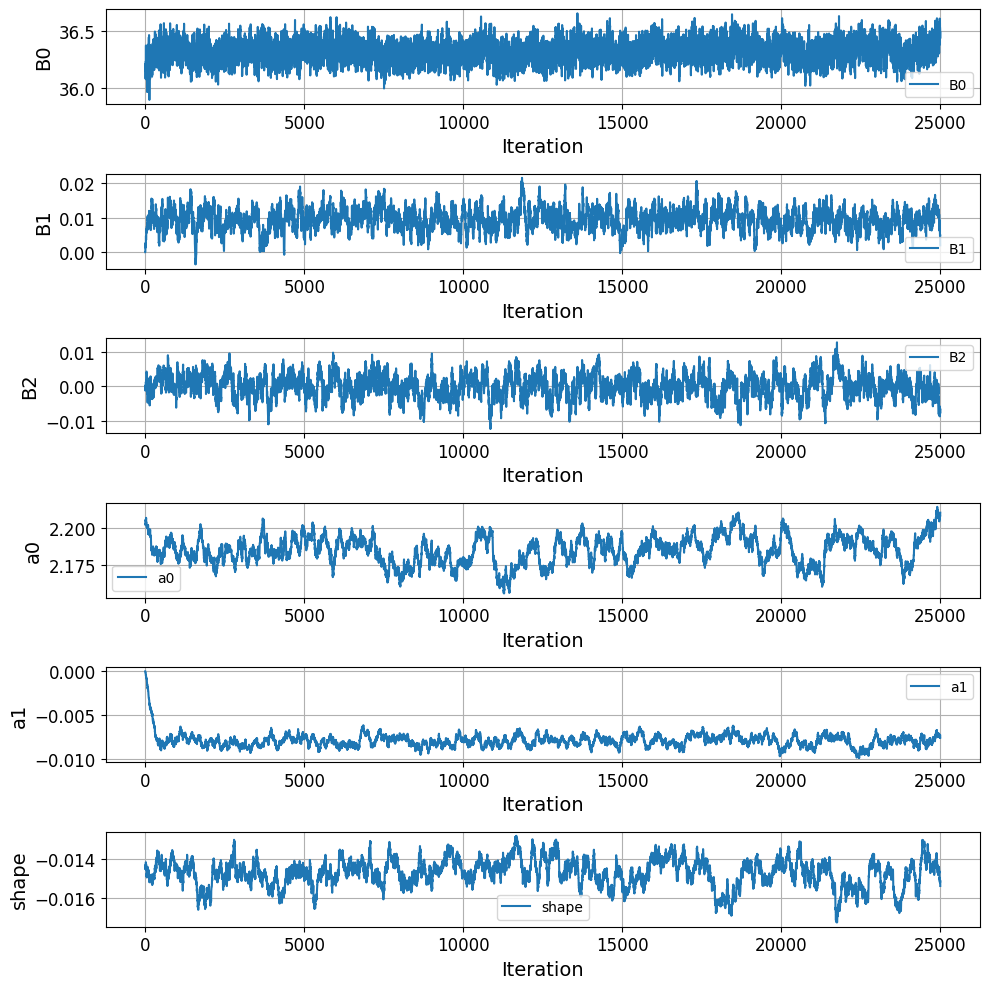

In [11]:
ns.plot_trace(samples, config,fig_size=(10,10))

#### Plotting the posterior histograms of the non-stationary GEV parameters

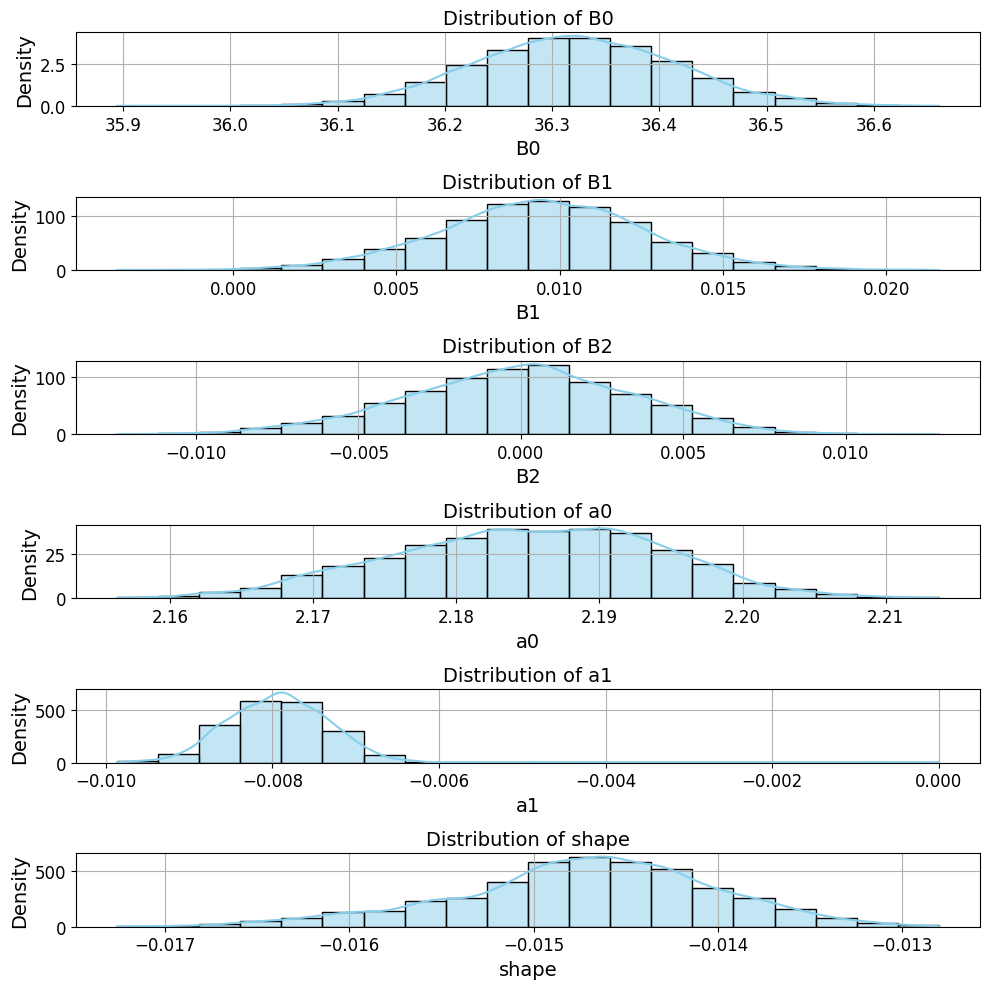

In [12]:
ns.plot_posterior(samples, config,fig_size=(10,10))

#### Implementation of Metropolis-adjusted Langevin Algorithm

MALA explores the posterior more efficiently than random-walk Metropolis by using gradient information. However, our use of a high temperature (T) flattens the posterior, causing wider and possibly multimodal samples. Reducing T would improve convergence but increase computation time.
Future versions will focus on improving this trade-off between accuracy and efficiency. 

In [140]:
samples, a_rate = sampler.MH_Mala(
    num_samples=10000,
    initial_params=initial_params,
    step_sizes=[0.02, 0.001, 0.001, 0.001, 0.0001, 1e-4],
    T=7
)

In [143]:
print(f"acceptance_rate : {a_rate}")
np.set_printoptions(suppress=True, precision=6)
print(f"Sample mean : {samples.mean(axis=0)}")

acceptance_rate : 0.4813
Sample mean : [36.473354  0.046001  0.037779  2.223464 -0.00256  -0.014129]


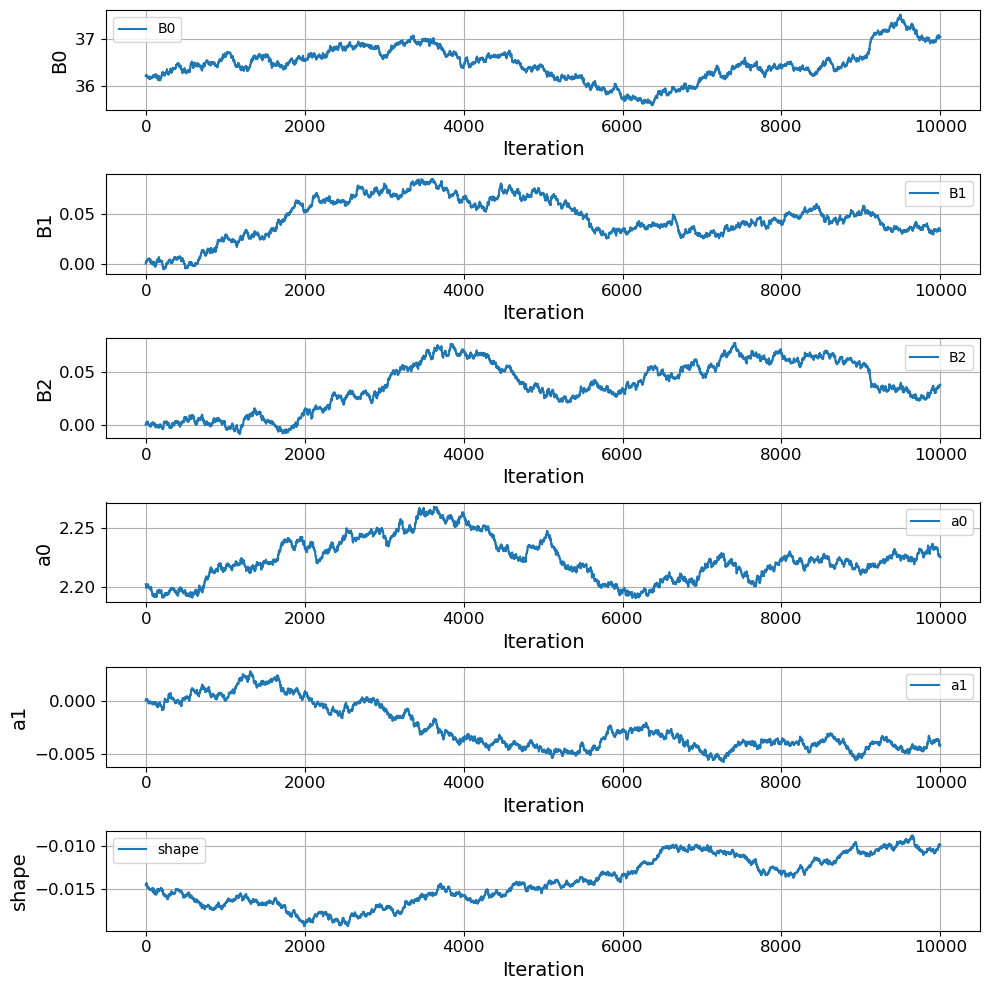

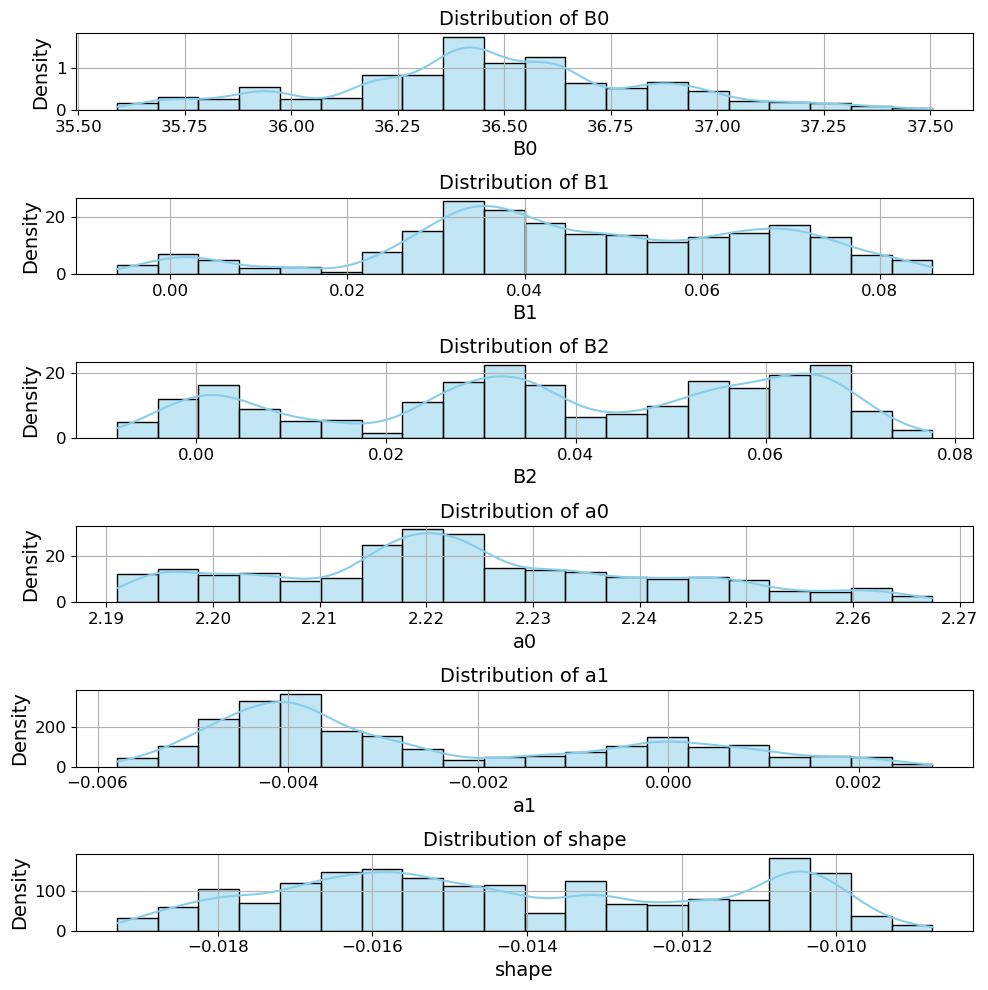

In [144]:
ns.plot_trace(samples, config, fig_size=(10,10))
ns.plot_posterior(samples, config, fig_size=(10,10))

#### Implementation of Hamiltonian Monte Carlo

This implementation uses standard HMC with fixed step size and leapfrog steps to sample from the posterior. HMC generally samples more efficiently than MALA and random-walk Metropolis by exploring distant regions with higher acceptance rates. Here, a high temperature is used to flatten the posterior and speed up demonstration, but it may reduce sampling accuracy. Future versions will incorporate NUTS and adaptive step-size tuning to improve sampling efficiency and computation time.

In [ ]:
samples, a_rate = sampler.MH_Hmc(
    num_samples=5000,
    initial_params=initial_params,
    step_size = 0.005,
    T = 5
)

In [148]:
print(f"acceptance_rate : {a_rate}")
np.set_printoptions(suppress=True, precision=6)
print(f"Sample mean : {samples.mean(axis=0)}")

acceptance_rate : 0.1576
Sample mean : [36.57761   0.009592  0.000333  2.201337 -0.008033 -0.014571]


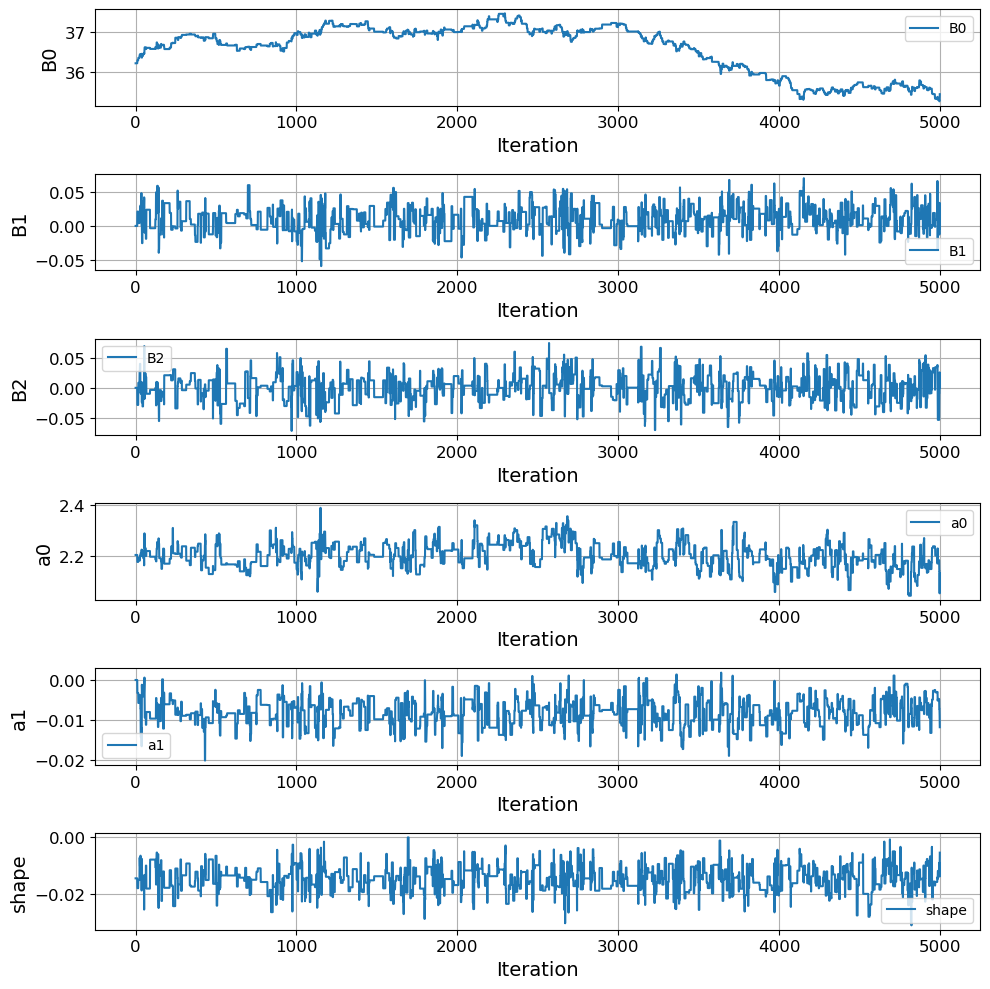

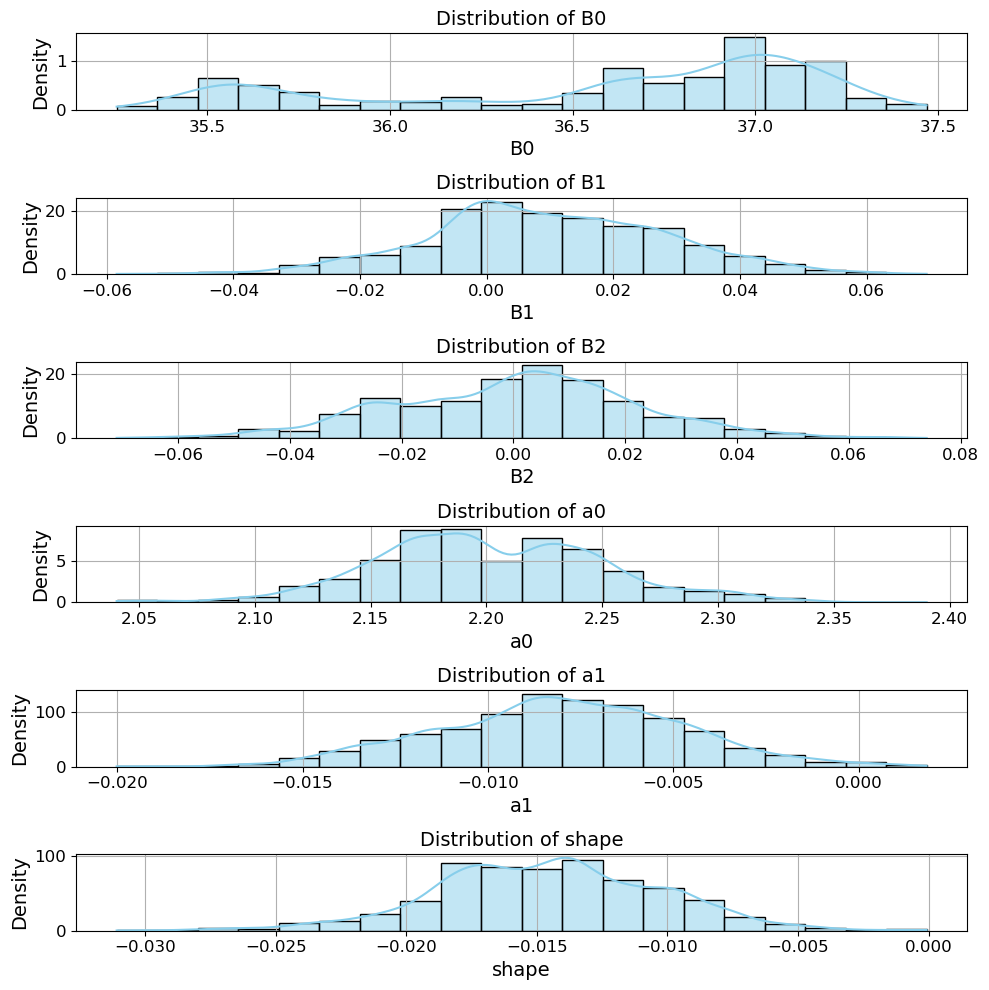

In [149]:
ns.plot_trace(samples, config, fig_size=(10,10))
ns.plot_posterior(samples, config, fig_size=(10,10))